In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 6)

In [2]:
data = loadmat('annthyroid.mat')
X = data['X']
y = data['y'].ravel()

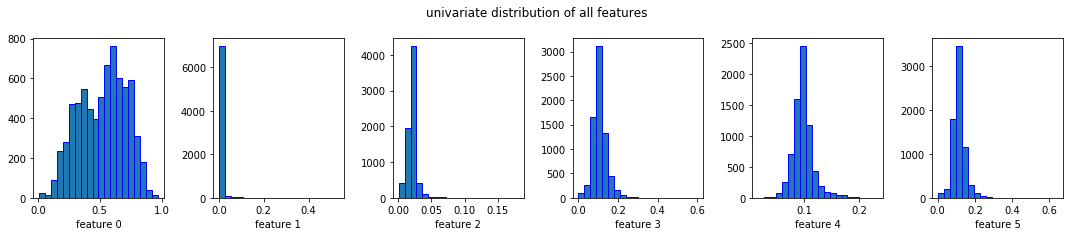

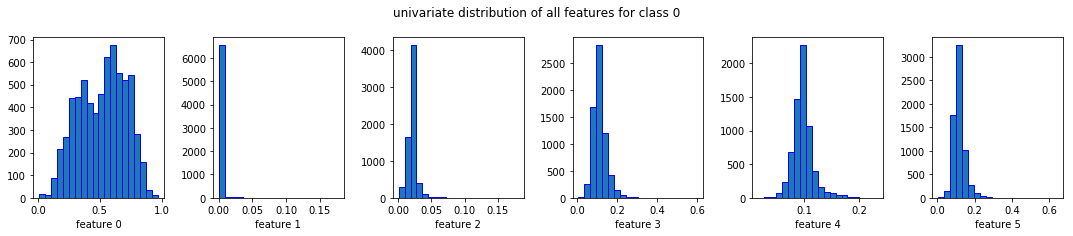

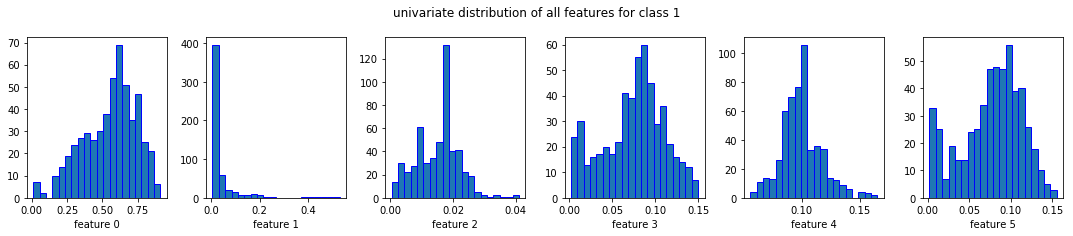

In [5]:
# univariate distribution of all features
plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.hist(X[:,i], bins=20, edgecolor='b')
    plt.xlabel('feature {:d}'.format(i))
plt.suptitle('univariate distribution of all features', y=1.08)
plt.tight_layout()

# univariate distribution of all features for class 0
plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.hist(X[y == 0][:,i], bins=20, edgecolor='b')
    plt.xlabel('feature {:d}'.format(i))
plt.suptitle('univariate distribution of all features for class 0', y=1.08)
plt.tight_layout()

# univariate distribution of all features for class 1
plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.hist(X[y == 1][:,i], bins=20, edgecolor='b')
    plt.xlabel('feature {:d}'.format(i))
plt.suptitle('univariate distribution of all features for class 1', y=1.08)
plt.tight_layout()

(7200, 2)


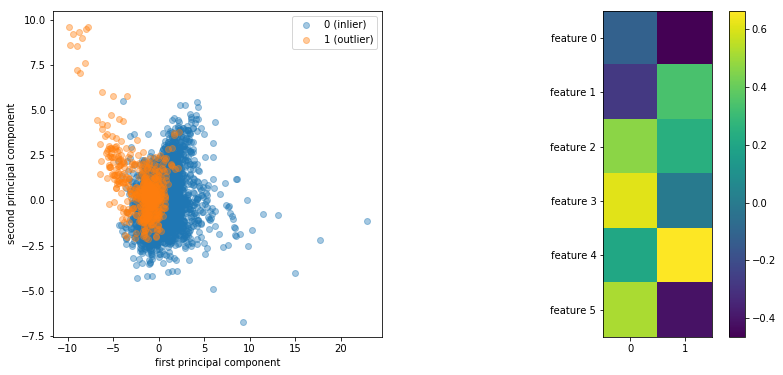

In [6]:
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(X)
print(X_pca_scaled.shape)

plt.subplot(1, 2, 1)
plt.scatter(X_pca_scaled[y == 0][:, 0], X_pca_scaled[y == 0][:, 1], label='0 (inlier)', alpha=0.4)
plt.scatter(X_pca_scaled[y == 1][:, 0], X_pca_scaled[y == 1][:, 1], label='1 (outlier)', alpha=0.4)
plt.legend()
plt.xlabel("first principal component")
plt.ylabel("second principal component")

plt.subplot(1, 2, 2)
components = pca_scaled.steps[1][1].components_
plt.imshow(components.T)
plt.xticks(range(2))
plt.yticks(range(6), ['feature {:d}'.format(i) for i in range(6)])
plt.colorbar()

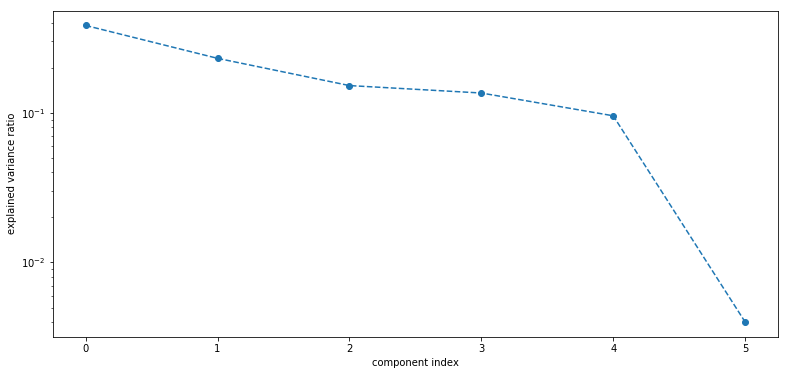

In [7]:
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=6))
X_pca_scaled = pca_scaled.fit_transform(X)

plt.semilogy(pca_scaled.steps[1][1].explained_variance_ratio_, 'o--')
plt.xlabel('component index')
plt.ylabel('explained variance ratio')

5 might be a good number of principal components.

### 1.2 Visualize the data using t-SNE

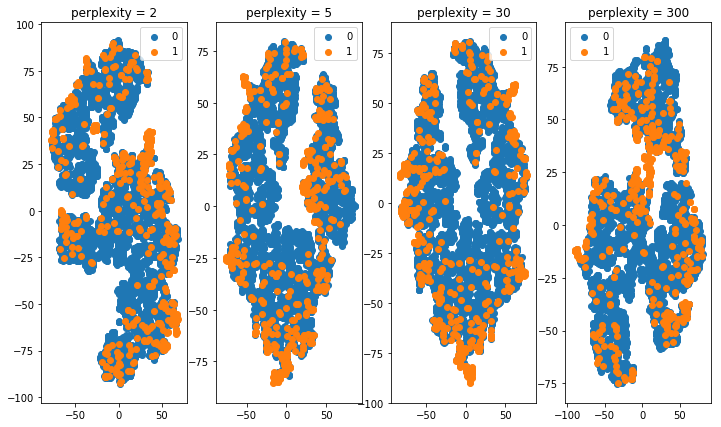

In [80]:
X_tsnes = []
for i, perplexity in enumerate([2, 5, 30, 100, 300]):
    plt.subplot(1, 4, i + 1)
    X_tsne = TSNE().fit_transform(X)
    X_tsnes.append(X_tsne)
    plt.scatter(X_tsne[y == 0][:, 0], X_tsne[y == 0][:, 1], label=0)
    plt.scatter(X_tsne[y == 1][:, 0], X_tsne[y == 1][:, 1], label=1)
    plt.legend()
    plt.title('perplexity = {:d}'.format(perplexity))

### 2.1: Use KMeans, Agglomerative Clustering (with ward linkage) and DBSCAN to cluster the data.

In [60]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward

In [62]:
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [ 861  417 1027  747 1263  146 1022  482 1215   20]


Text(0,0.5,'Cluster distance')

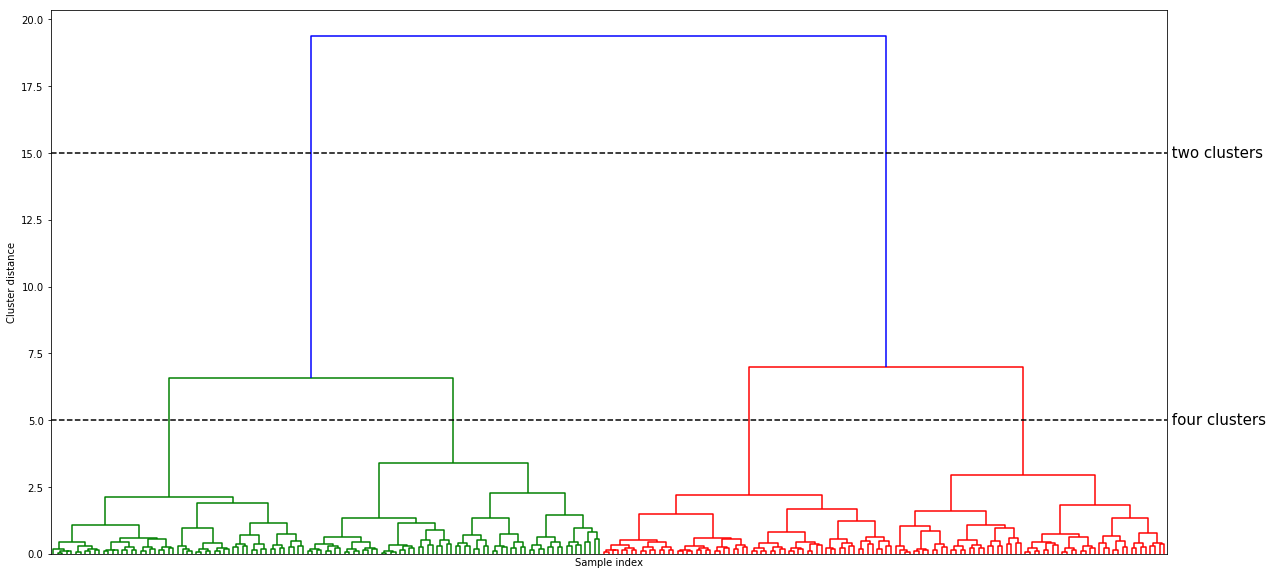

In [85]:
linkage_array = ward(X)
# now we plot the dendrogram for the linkage_array
# containing the distances between clusters
plt.figure(figsize=(20, 10))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
# Mark the cuts in the tree that signify two or three clusters
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [15.0, 15.0], '--', c='k')
ax.plot(bounds, [5.0, 5.0], '--', c='k')
ax.text(bounds[1], 15.0, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 5.0, ' four clusters', va='center', fontdict={'size': 15})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

In [99]:
# extract clusters with ward agglomerative clustering
agg = []
for n_clusters in range(6, 15):
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels_agg = agglomerative.fit_predict(X)
    print("Cluster sizes: {}, agglomerative clustering: {}".format(n_clusters, np.bincount(labels_agg)))

Cluster sizes: 6, agglomerative clustering: [1049 1104 2034  962 1024 1027]
Cluster sizes: 7, agglomerative clustering: [2034 1104 1027  962 1024  913  136]
Cluster sizes: 8, agglomerative clustering: [1104  962 1027 1006 1024  913  136 1028]
Cluster sizes: 9, agglomerative clustering: [ 754  962 1027 1006 1024  913  136 1028  350]
Cluster sizes: 10, agglomerative clustering: [ 962 1006 1027 1028 1024  913  136  730  350   24]
Cluster sizes: 11, agglomerative clustering: [1006 1028 1027  609 1024  913  136  730  350   24  353]
Cluster sizes: 12, agglomerative clustering: [1027 1028  913  609 1024  520  136  730  350   24  353  486]
Cluster sizes: 13, agglomerative clustering: [1028  609  913  730 1024  520  136  974  350   24  353  486   53]
Cluster sizes: 14, agglomerative clustering: [ 913  609  136  730 1024  520  513  974  350   24  353  486   53  515]


In [75]:
for eps in 10 ** np.linspace(-6, 0, 30):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X)
    print("eps: {}, Number of clusters: {}".format(eps, len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))

eps: 1e-06, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]
eps: 1.6102620275609392e-06, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]
eps: 2.592943797404667e-06, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]
eps: 4.1753189365604e-06, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]
eps: 6.723357536499335e-06, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]
eps: 1.082636733874054e-05, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]
eps: 1.7433288221999873e-05, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]
eps: 2.8072162039411757e-05, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]
eps: 4.520353656360241e-05, Number of clusters: 10
Cluster sizes: [7142

## 3.1 Assume that you know the proportion of outliers. Use EllipticEnvelope, OneClassSVM and IsolationForest to detect outliers. Without using the ground-truth, can you tell which one gave the best results? Why?

In [4]:
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [6]:
ratio = (y == 1).sum() / len(y)
print('The proportion of outliers is {:.3f}'.format(ratio))

The proportion of outliers is 0.074


### EllipticEnvelope

In [38]:
# EllipticEnvelope
ee = EllipticEnvelope(contamination=ratio).fit(X)
ee_pred = ee.predict(X)
print((ee_pred == -1).mean())

0.07416666666666667


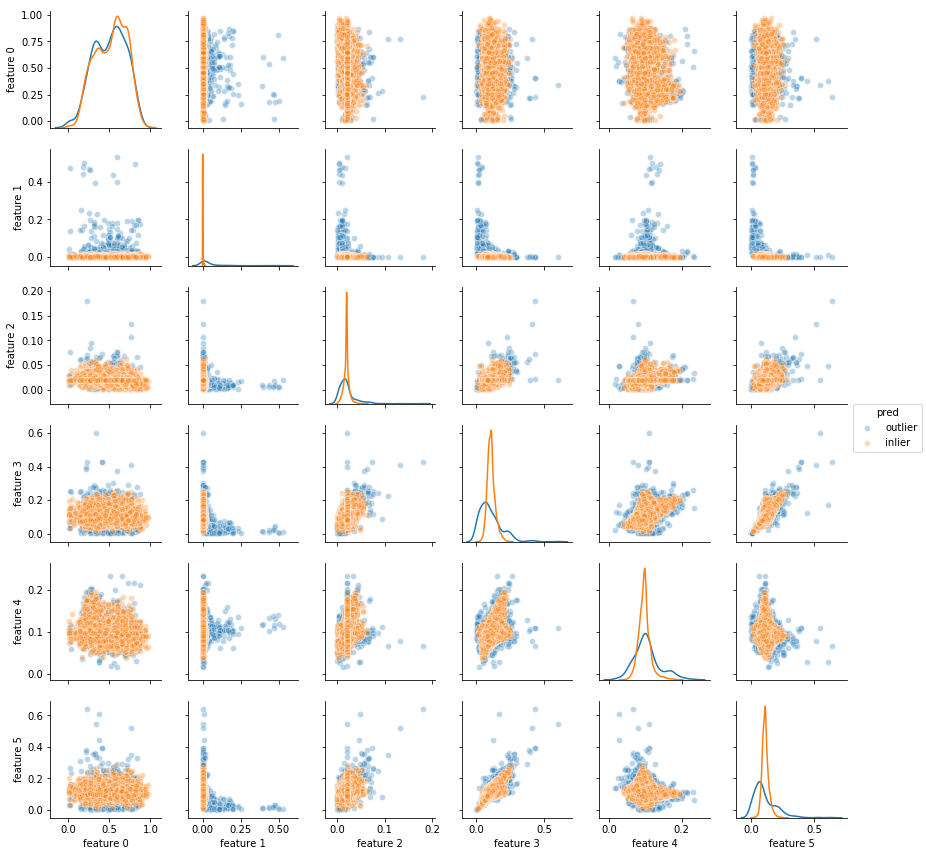

In [58]:
# create dataframe from data in X
dataframe = pd.DataFrame(X, columns=['feature {:d}'.format(i) for i in range(6)])
# create a scatter matrix from the dataframe, color by pred
dataframe['pred'] = np.array(['inlier' if i == 1 else 'outlier' for i in ee_pred])
sns.pairplot(dataframe, hue='pred', hue_order=['outlier', 'inlier'], size=2, 
             diag_kind='kde', plot_kws={'alpha': 0.3})

### OneClassSVM

In [40]:
# OneClassSVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
oneclass = OneClassSVM(nu=ratio).fit(X_scaled)
oneclass_pred = oneclass.predict(X_scaled)
print((oneclass_pred == -1).mean())

0.07458333333333333


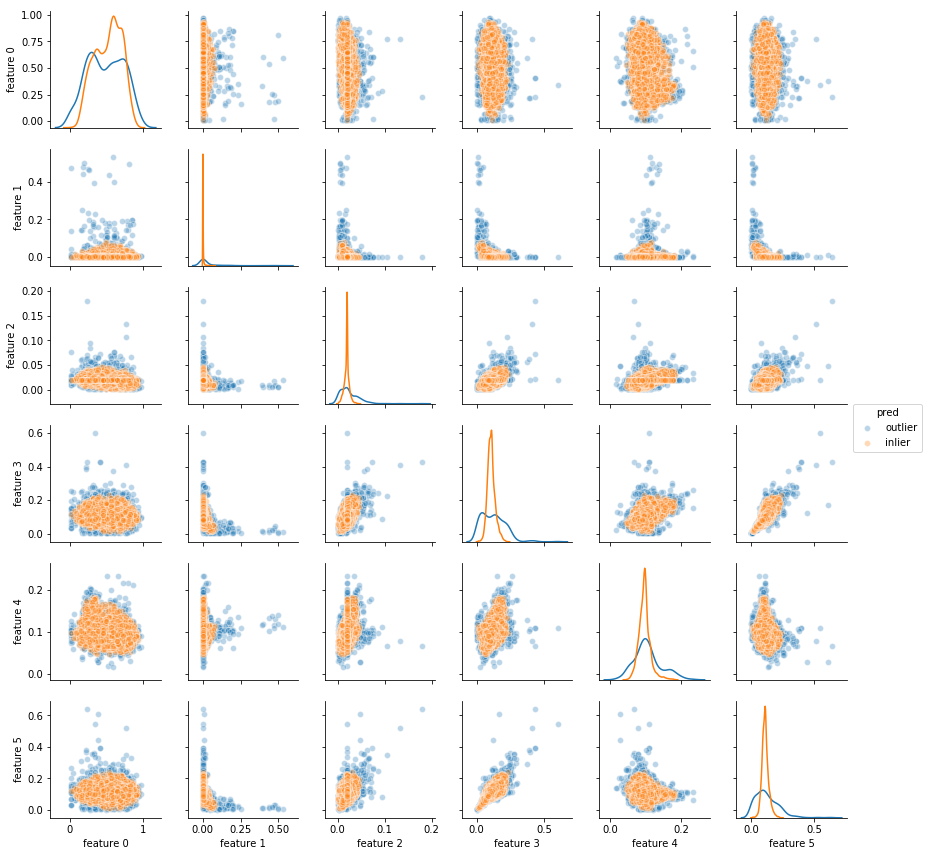

In [48]:
# create dataframe from data in X
dataframe = pd.DataFrame(X, columns=['feature {:d}'.format(i) for i in range(6)])
# create a scatter matrix from the dataframe, color by pred
dataframe['pred'] = np.array(['inlier' if i == 1 else 'outlier' for i in oneclass_pred])
sns.pairplot(dataframe, hue='pred', hue_order=['outlier', 'inlier'], size=2, 
             diag_kind='kde', plot_kws={'alpha': 0.3})

### IsolationForest

In [42]:
# IsolationForest
isolation = IsolationForest(contamination=ratio).fit(X)
isolation_pred = isolation.predict(X)
print((isolation_pred == -1).mean())

0.07416666666666667


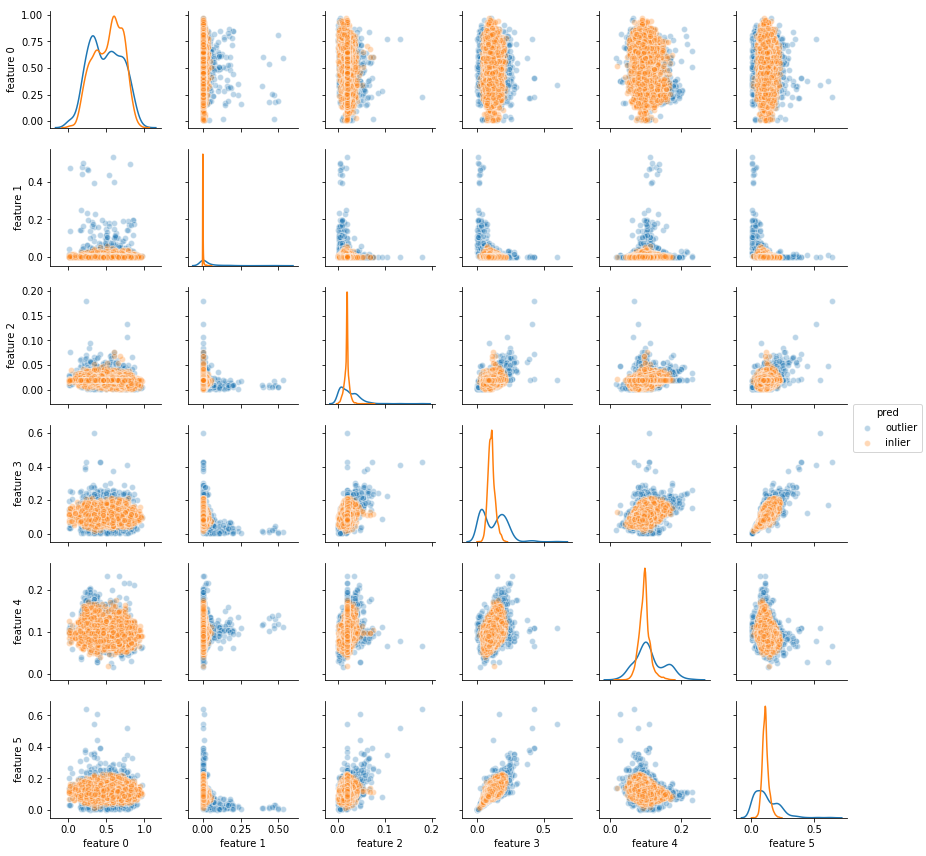

In [49]:
# create dataframe from data in X
dataframe = pd.DataFrame(X, columns=['feature {:d}'.format(i) for i in range(6)])
# create a scatter matrix from the dataframe, color by pred
dataframe['pred'] = np.array(['inlier' if i == 1 else 'outlier' for i in isolation_pred])
sns.pairplot(dataframe, hue='pred', hue_order=['outlier', 'inlier'], size=2, 
             diag_kind='kde', plot_kws={'alpha': 0.3})

## 3.2 Use the ground-truth to evaluate the different outlier detection approaches using AUC and average precision. How can you compare their quality to the clustering approaches from Task 2?

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve

OneClassSVM roc_auc_score: 0.489
OneClassSVM average_precision_score: 0.073
IsolationForest roc_auc_score: 0.829
IsolationForest average_precision_score: 0.337
EllipticEnvelope roc_auc_score: 0.919
EllipticEnvelope average_precision_score: 0.505


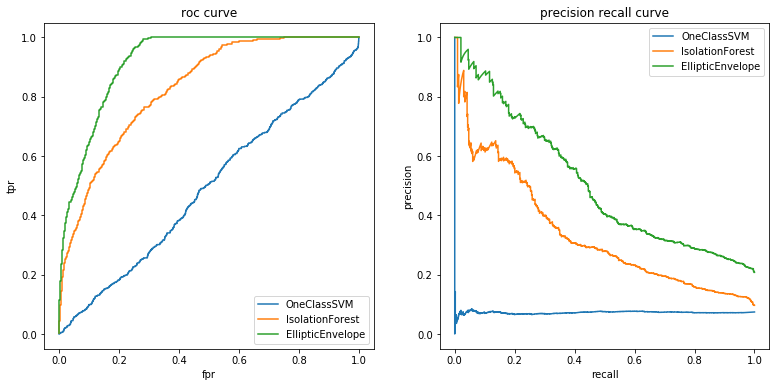

In [72]:
'''
ee.decision_function(X): 
    positive for an inlier and negative for an outlier
oneclass.decision_function(X_scaled): 
    Signed distance is positive for an inlier and negative for an outlier.
isolation.decision_function(X):
    the lower, the more abnormal
'''
models = {'EllipticEnvelope': ee, 'OneClassSVM': oneclass, 'IsolationForest': isolation}
for name, model in models.items():
    # roc curve
    plt.subplot(1, 2, 1)
    print('{} roc_auc_score: {:.3f}'.format(name, roc_auc_score(y, -model.decision_function(X))))
    fpr, tpr, _ = roc_curve(y, -model.decision_function(X))
    plt.plot(fpr, tpr, label=name)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('roc curve')
    plt.legend()

    # precision recall curve
    print('{} average_precision_score: {:.3f}'.format(name, average_precision_score(y, -model.decision_function(X))))
    precision , recall, _ = precision_recall_curve(y, -model.decision_function(X))
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=name)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision recall curve')
    plt.legend()